In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Master Search & Discovery Template

In [63]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.patches as mpatches

from shapely import wkt
import geopandas as gpd

import pandas as pd
import csv
from datetime import datetime

import numpy as np

from utils.utils import reproFijiGDF

### Key Inputs

In [3]:
aois_dir = "../CS_AoIs/"
world_borders = gpd.read_file('../Ancillary_Datasets/TM_WORLD_BORDERS-0.2/TM_WORLD_BORDERS-0.2.shp')
aois = world_borders.loc[world_borders.NAME == 'Solomon Islands']
# in case of mulitple shapefiles
# aois = [gpd.read_file(x) for x in glob.glob(aois_dir + '*.geojson')] # load aois
# aois = gpd.GeoDataFrame(pd.concat(aois)) # spatial join aois
aois.head()

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry
19,BP,SB,SLB,90,Solomon Islands,2799,472419,9,54,160.109,-9.611,(POLYGON ((166.8505250000001 -11.6969449999999...


In [5]:
# repro required because fiji
aois_fjcrs = reproFijiGDF(aois)
aois_fjcrs.head()

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry,repro
60,FJ,FJ,FJI,242,Fiji,1827,828046,9,54,177.974,-17.819,(POLYGON ((-178.7077639999999 -20.674441999999...,"(POLYGON ((2264895.9646006 3591255.7909973, 22..."


### Determine S2 & LS tile/granule overlaps

In [4]:
# Load landsat & sentinel-2 world tiles
world_s2_granules = gpd.read_file('../Ancillary_Datasets/sentinel2_tiles_world/sentinel2_tiles_world.shp')
#world_ls_granules = gpd.read_file('../Ancillary_Datasets/WRS2_descending.shp')

In [5]:
# Create bool for intersection between any tiles 
print ( 'Time: {}'.format(str(datetime.today().strftime('%Y-%m-%d %H:%M:%S'))) )
for n, g in zip(aois.NAME, aois.geometry):
#     world_ls_granules[n] = world_ls_granules.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))
    world_s2_granules[n] = world_s2_granules.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))
    print ( 'Time: {}'.format(str(datetime.today().strftime('%Y-%m-%d %H:%M:%S'))) )

Time: 2019-09-04 14:19:16
Time: 2019-09-04 14:19:48


In [6]:
# Filter based on any intersections
# world_ls_granules['Solomon Islands'] = world_ls_granules[world_ls_granules[aois.NAME.values]].any(1)
# ls_grans = world_ls_granules[world_ls_granules.DY==True]
world_s2_granules['Solomon Islands'] = world_s2_granules[world_s2_granules[aois.NAME.values]].any(1)
s2_grans = world_s2_granules[world_s2_granules['Solomon Islands']==True]
world_s2_granules = None
# world_ls_granules = None

In [10]:
# repro bespoke to fiji
s2_grans_fijicrs = reproFijiGDF(s2_grans)
s2_grans_fijicrs.head(2)

,Name,geometry,Fiji,repro
380,01KAA,POLYGON Z ((180.0000000000001 -18.152986774999...,True,POLYGON Z ((2132238.92192499 3871958.0558857 1...
382,01KAB,POLYGON Z ((180.0000000000001 -17.250481611999...,True,POLYGON Z ((2132901.57942978 3971849.11204117 ...


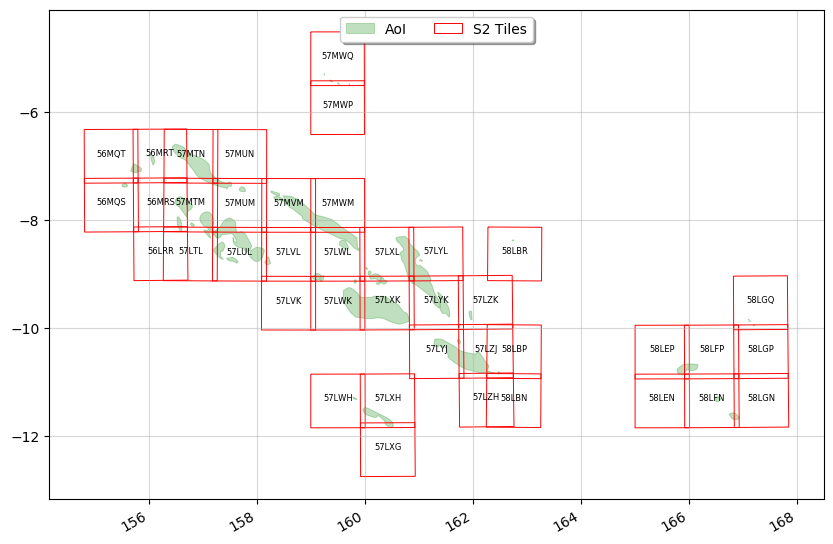

In [7]:
fig, ax = plt.subplots(figsize=(10,10),dpi=100)
fig.autofmt_xdate()
leg_patches=[]

aois.plot(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, ax=ax)
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label='AoI'))

s2_grans.plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax)
leg_patches.append(mpatches.Patch(facecolor="none", edgecolor='r', lw=0.7, label='S2 Tiles'))

s2_grans.apply(lambda x: ax.annotate(s=x.Name, xy=x.geometry.centroid.coords[0], ha='center', fontsize=6),axis=1)

ax.legend(handles=leg_patches, loc='upper center', shadow=True, ncol=5);
ax.grid(alpha=0.5);

### Sentinel-2 L1C vs L2A Target List

In [132]:
s2_tiles = list(s2_grans.Name.values)
len(s2_tiles)

40

In [9]:
gc = pd.read_csv('../Ancillary_Datasets/L2_index.csv.gz')
gc_fj = gc[ gc.MGRS_TILE.isin(s2_tiles) ]
gc = None
gc_fj.to_csv('./s2l2agcloudhitlist.csv', sep=',', index=False)

/home/tj/miniconda3/envs/cs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
gc = pd.read_csv('../Ancillary_Datasets/gc_index.csv.gz')
gc_fj1 = gc[ gc.MGRS_TILE.isin(s2_tiles) ]
gc = None
gc_fj1.to_csv('./s2l1cgcloudhitlist.csv', sep=',', index=False)

/home/tj/miniconda3/envs/cs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


KeyboardInterrupt: 

In [60]:
gc_fj = gc_fj.sort_values('CLOUD_COVER', ascending=True)
gc_fj = gc_fj[pd.notnull(gc_fj['TOTAL_SIZE'])]
gc_fj['sizeMB'] = gc_fj.TOTAL_SIZE/1024/1024

56LRR, S2A_MSIL2A_20190223T235741_N0211_R030_T56LRR_20190224T014653, 4.79, 846.3
56MQS, S2A_MSIL2A_20190508T000731_N0212_R073_T56MQS_20190508T022148, 10.94, 697.3 T1 ****
1783297
56MQT, S2B_MSIL2A_20190304T000729_N0211_R073_T56MQT_20190304T015407, 8.01, 848.05 T1 ****
1046026
56MRS, S2A_MSIL2A_20190812T235741_N0213_R030_T56MRS_20190813T014708, 1.83, 725.8
56MRT, S2B_MSIL2A_20190807T235749_N0213_R030_T56MRT_20190808T014706, 2.61, 803.67
57LTL, S2A_MSIL2A_20190223T235741_N0211_R030_T57LTL_20190224T014653, 9.27, 938.11
57LUL, S2B_MSIL2A_20190814T234749_N0213_R130_T57LUL_20190815T014102, 13.39, 551.19 T1 ****
2627627
57LVK, S2B_MSIL2A_20190225T234739_N0211_R130_T57LVK_20190226T032107, 0.94, 837.31
57LVL, S2B_MSIL2A_20190225T234739_N0211_R130_T57LVL_20190226T032107, 1.61, 776.32
57LWH, S2B_MSIL2A_20190225T234739_N0211_R130_T57LWH_20190226T032107, 0.85, 796.21 T1 ****
990935
57LWK, S2B_MSIL2A_20190225T234739_N0211_R130_T57LWK_20190226T032107, 1.57, 976.58
57LWL, S2A_MSIL2A_20190809T234751_N0

/home/tj/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


57LZK, S2B_MSIL2A_20190811T233819_N0213_R087_T57LZK_20190812T012954, 18.74, 875.38 T1 ****
2590751
57MTM, S2A_MSIL2A_20190812T235741_N0213_R030_T57MTM_20190813T014708, 3.56, 770.74


/home/tj/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


57MTN, S2A_MSIL2A_20190812T235741_N0213_R030_T57MTN_20190813T014708, 2.45, 814.7
57MUM, S2A_MSIL2A_20190812T235741_N0213_R030_T57MUM_20190813T014708, 6.05, 672.57 T1 ****
2602436


/home/tj/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


57MUN, S2A_MSIL2A_20190603T235741_N0212_R030_T57MUN_20190604T015103, 10.29, 813.69
57MVM, S2B_MSIL2A_20190225T234739_N0211_R130_T57MVM_20190226T032107, 8.57, 823.31
57MWM, S2B_MSIL2A_20190516T234749_N0212_R130_T57MWM_20190517T014032, 4.39, 744.92
57MWP, S2B_MSIL2A_20190406T234749_N0211_R130_T57MWP_20190407T014656, 1.89, 791.79
57MWQ, S2B_MSIL2A_20190406T234749_N0211_R130_T57MWQ_20190407T014656, 1.15, 721.97
58LBN, S2A_MSIL2A_20190224T232841_N0211_R044_T58LBN_20190225T012128, 0.31, 798.67
58LBP, S2B_MSIL2A_20190110T232839_N0211_R044_T58LBP_20190111T010849, 1.4, 843.76
58LBR, S2B_MSIL2A_20190808T232849_N0213_R044_T58LBR_20190809T012044, 5.02, 516.88 T1 ****
2553797
58LEN, S2A_MSIL2A_20190303T231851_N0211_R001_T58LEN_20190304T011207, 3.47, 901.68
58LEP, S2A_MSIL2A_20190621T231901_N0212_R001_T58LEP_20190622T010620, 3.21, 829.13
58LFN, S2A_MSIL2A_20190621T231901_N0212_R001_T58LFN_20190622T010620, 1.48, 808.51
58LFP, S2A_MSIL2A_20190621T231901_N0212_R001_T58LFP_20190622T010620, 2.81, 843.06


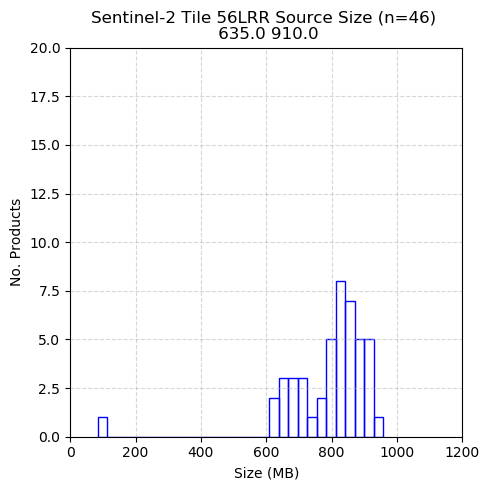

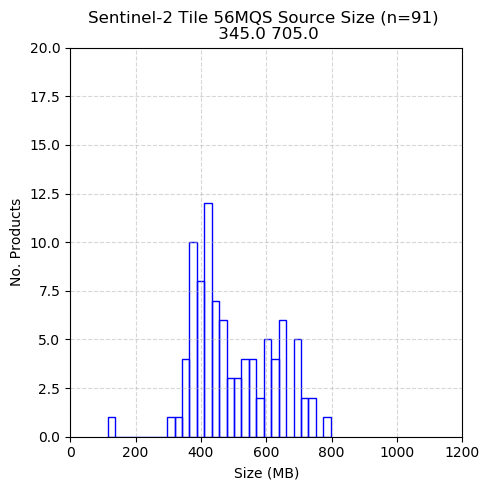

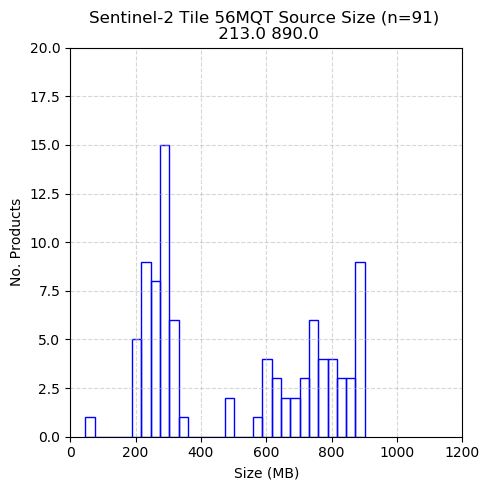

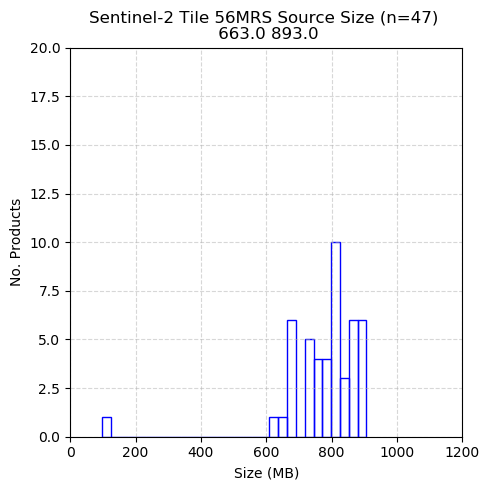

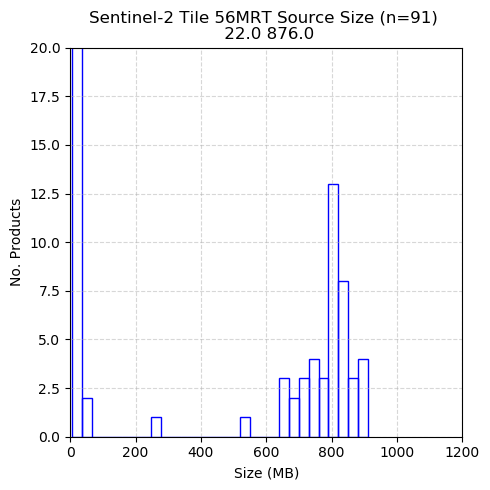

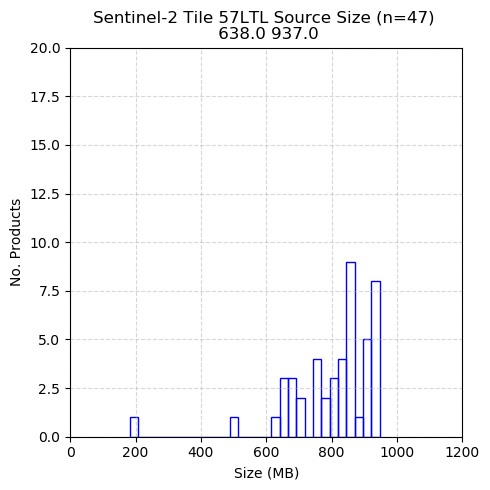

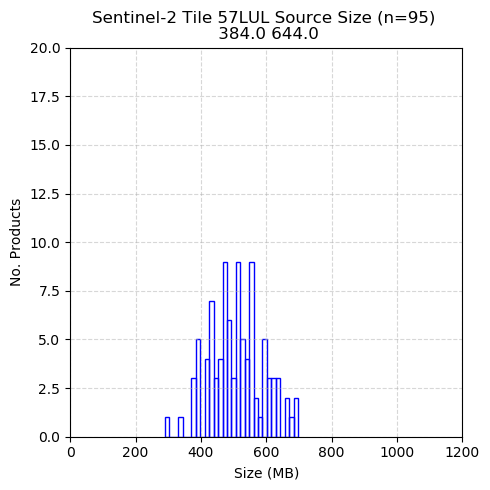

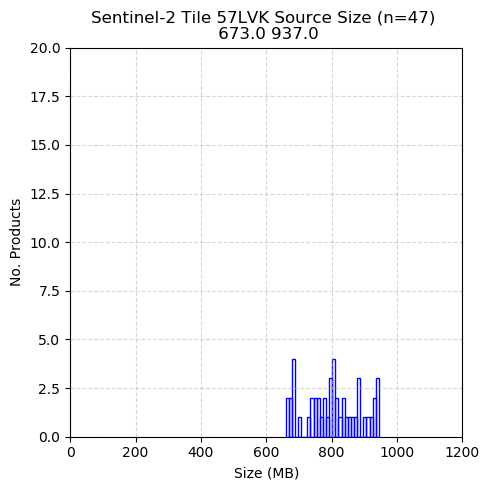

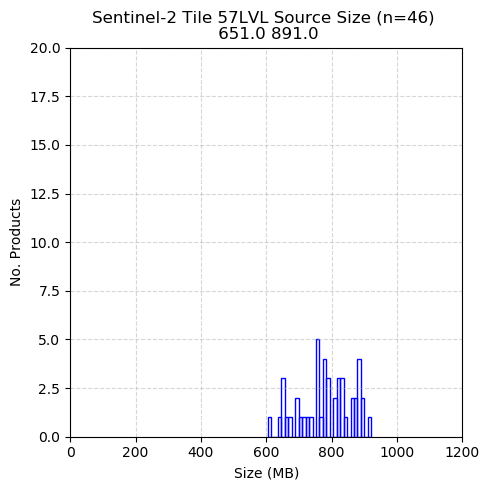

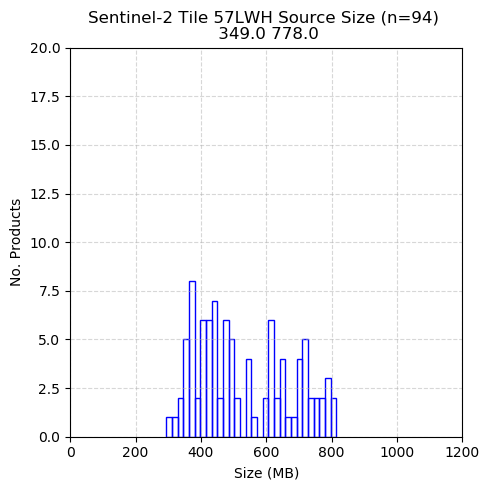

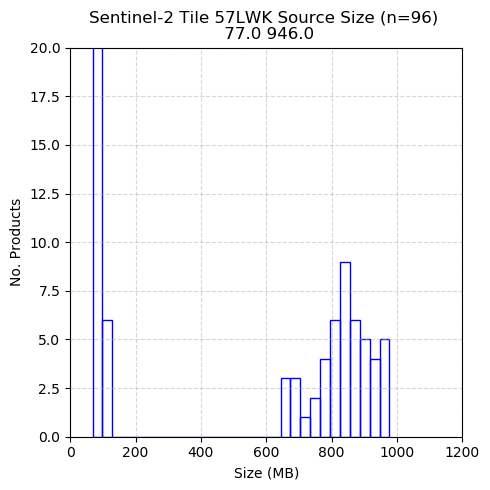

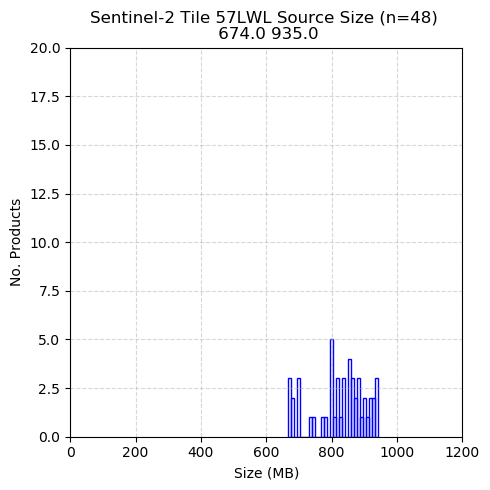

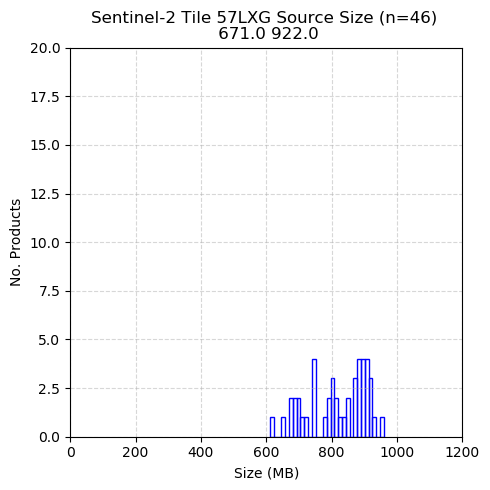

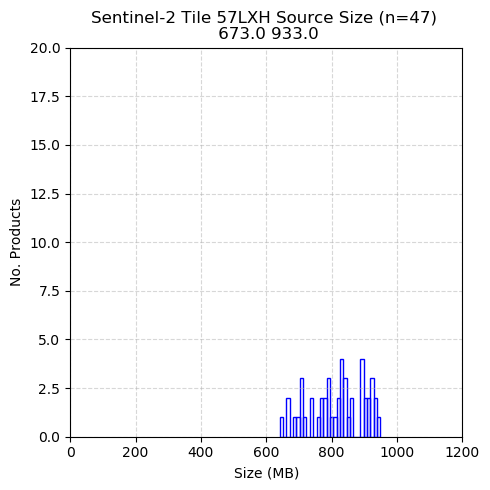

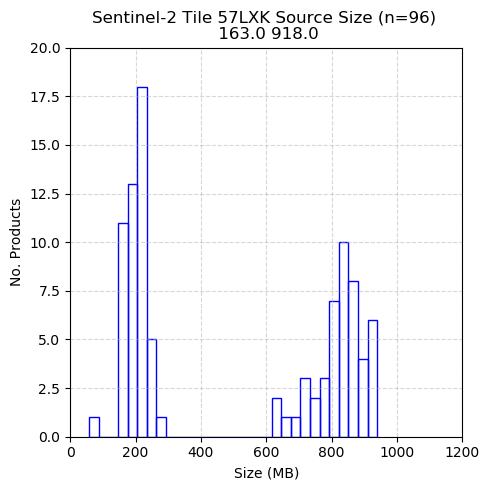

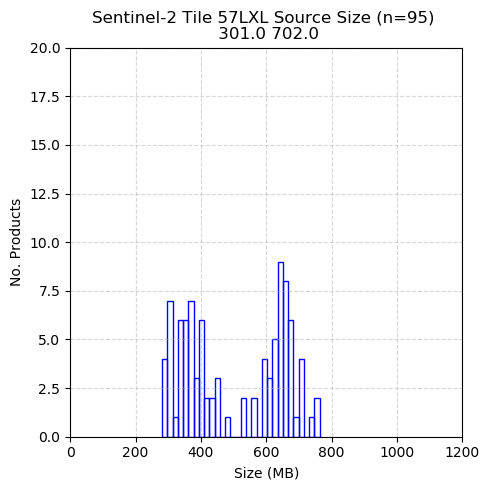

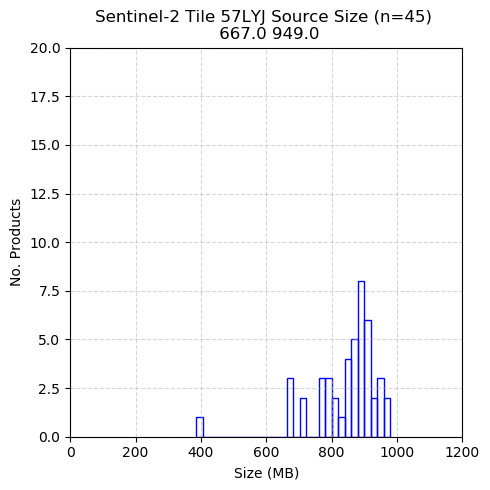

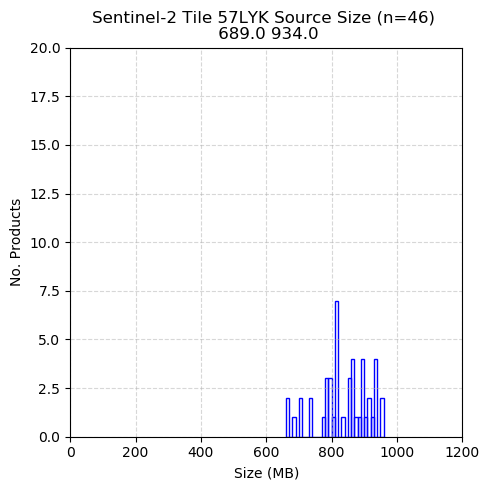

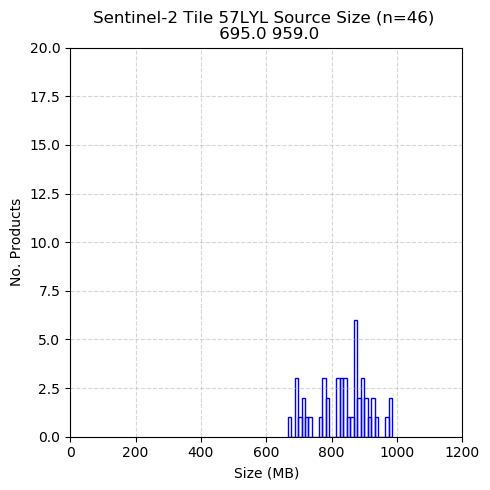

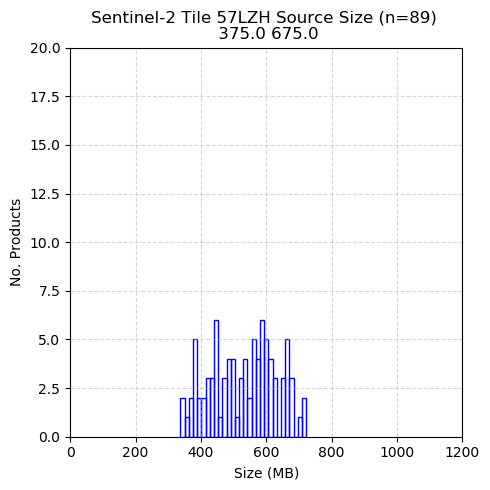

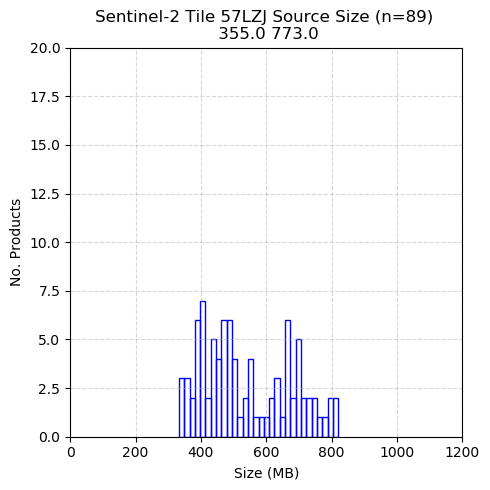

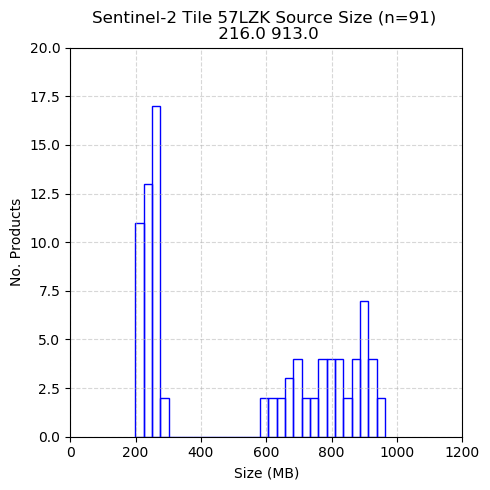

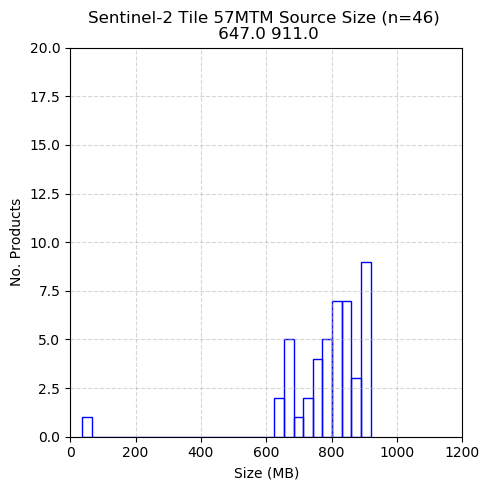

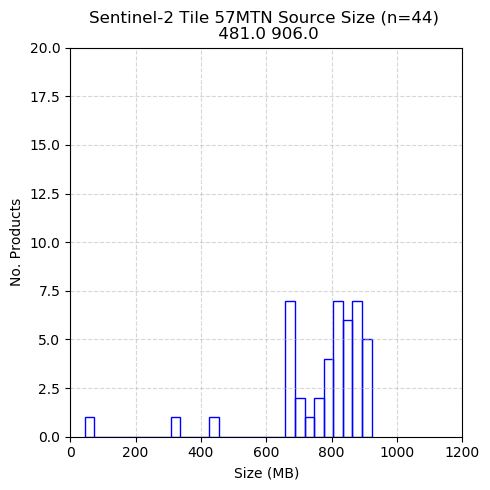

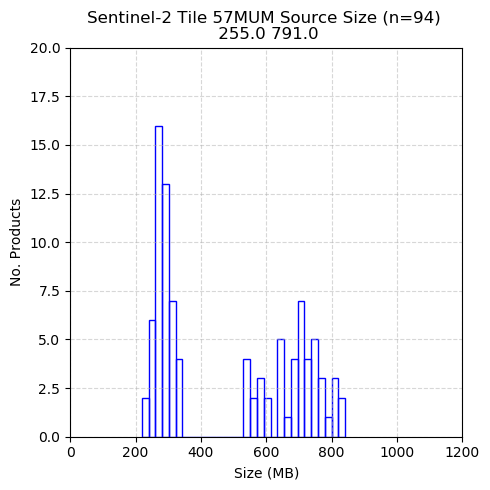

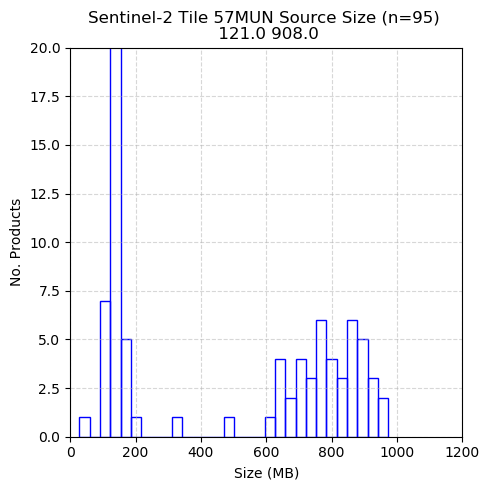

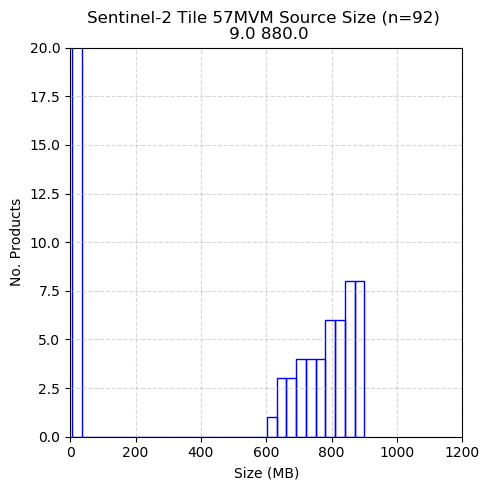

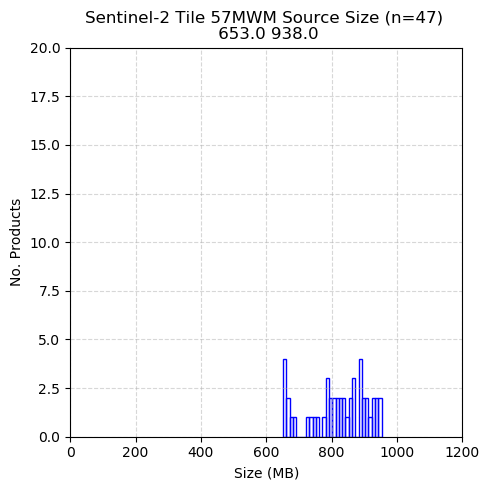

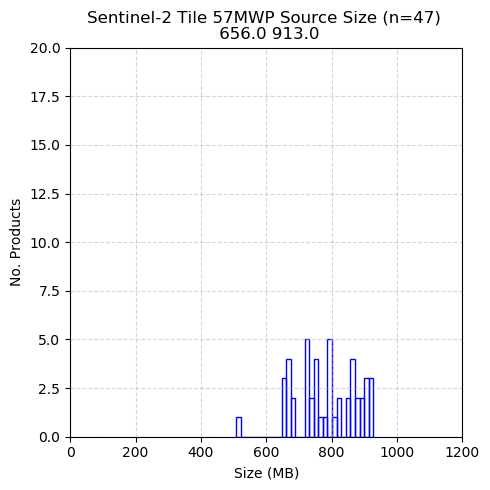

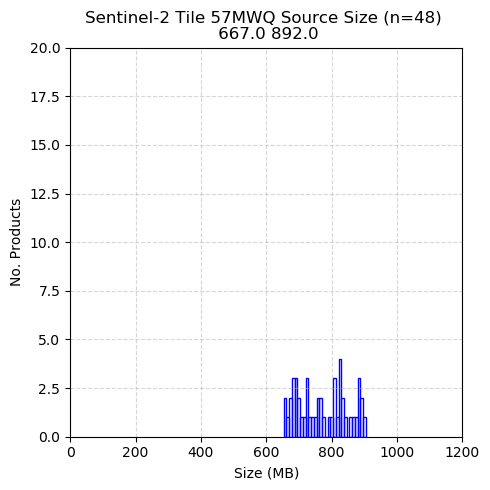

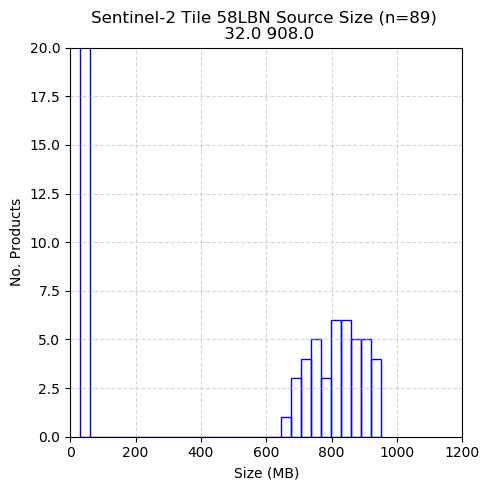

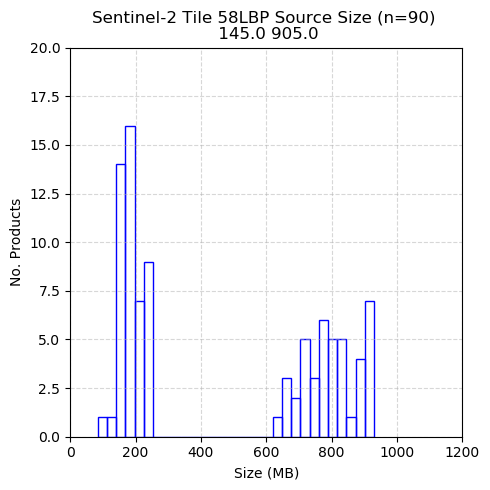

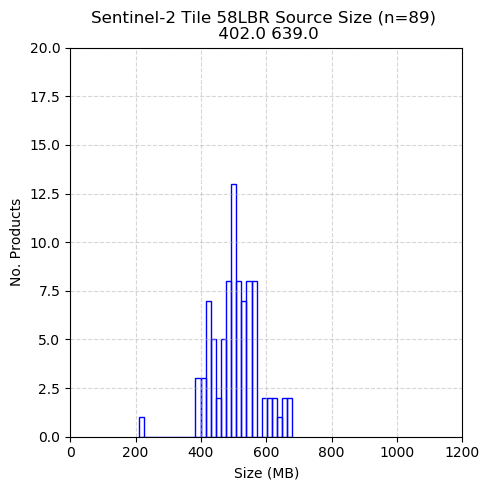

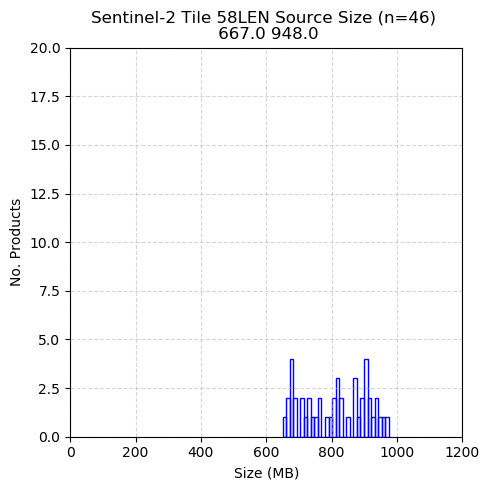

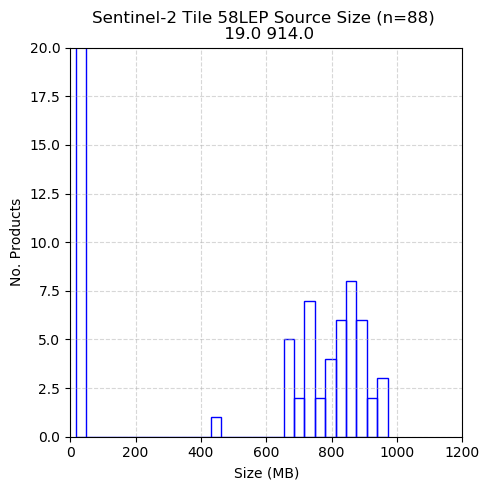

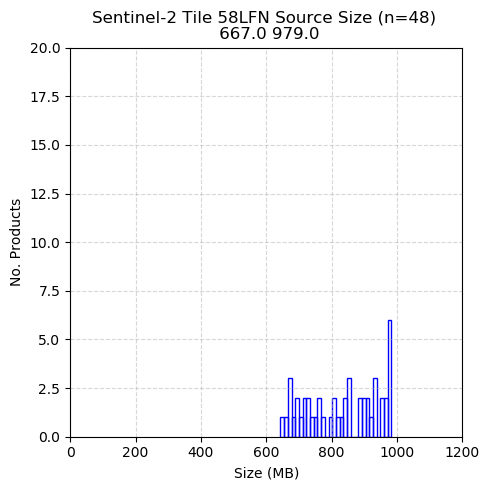

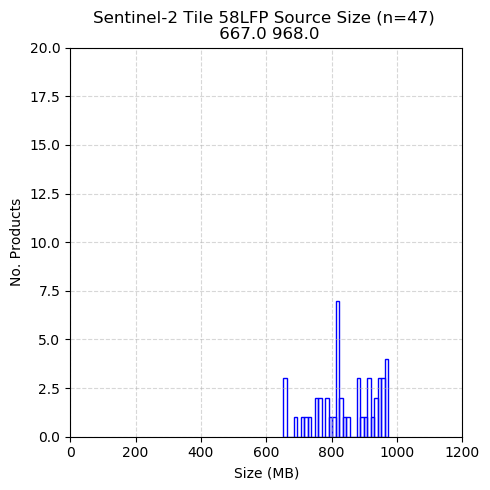

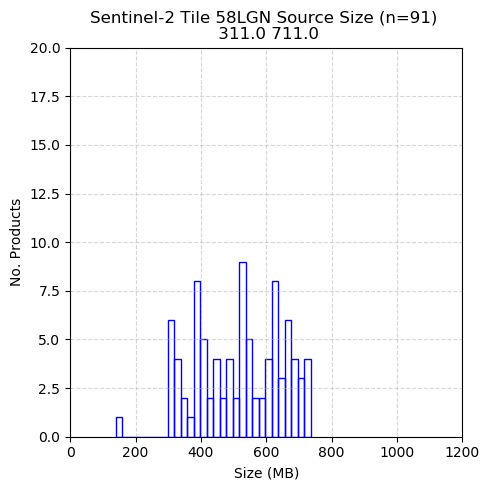

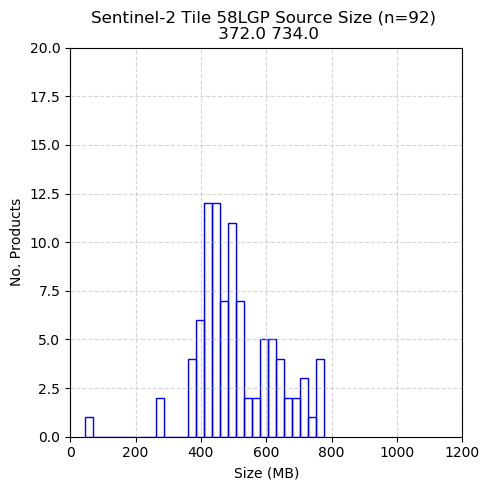

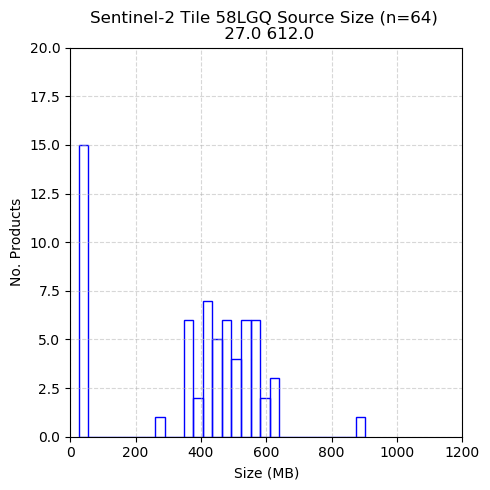

In [162]:
# fig, ax = plt.subplots(figsize=(10,10),dpi=100)

# candidates = [['Tile','Scene','Cloud','Size']]
candidates = {'Tile':[],
             'Scene':[],
             'Cloud':[],
             'Size':[]}

for t in s2_tiles:
    df = gc_fj.loc[gc_fj.MGRS_TILE == t]
    sz = df.sizeMB.values
    
    if (df.shape[0] <50):
        fig, ax = plt.subplots(figsize=(5,5),dpi=100)
        df.hist(column='sizeMB', bins=30, color='b', edgecolor='b', fc='None', ax=ax)
        ax.grid(alpha=0.5, linestyle='--');
        ax.set_ylabel("No. Products");
        ax.set_xlabel("Size (MB)");
        ax.set_ylim(0,20)
        ax.set_xlim(0,1200)
        ax.set_title("Sentinel-2 Tile {} Source Size (n={}) \n {} {}".format(
            t, df.shape[0], round(np.percentile(sz, 5),0), round(np.percentile(sz, 95),0)));
        fig.tight_layout();
        
        df = df.loc[df.sizeMB > 700]
        
        print("{}, {}, {}, {}".format(t, 
                                      df.head(1).PRODUCT_ID.values[0],
                                      round(df.head(1).CLOUD_COVER.values[0],2),
                                      round(df.head(1).sizeMB.values[0],2)))

        candidates['Tile'].append(t)
        candidates['Scene'].append(df.head(1).PRODUCT_ID.values[0])
        candidates['Cloud'].append(round(df.head(1).CLOUD_COVER.values[0],2))
        candidates['Size'].append(round(df.head(1).sizeMB.values[0],2))
        
    if (df.shape[0] >50) & (np.percentile(sz, 5) <200 ):        
        fig, ax = plt.subplots(figsize=(5,5),dpi=100)
        df.hist(column='sizeMB', bins=30, color='b', edgecolor='b', fc='None', ax=ax)
        ax.grid(alpha=0.5, linestyle='--');
        ax.set_ylabel("No. Products");
        ax.set_xlabel("Size (MB)");
        ax.set_ylim(0,20)
        ax.set_xlim(0,1200)
        ax.set_title("Sentinel-2 Tile {} Source Size (n={}) \n {} {}".format(
            t, df.shape[0], round(np.percentile(sz, 5),0), round(np.percentile(sz, 95),0)));
        fig.tight_layout();
        
        df = df.loc[df.sizeMB > 700]

        print("{}, {}, {}, {}".format(t, 
                                      df.head(1).PRODUCT_ID.values[0],
                                      round(df.head(1).CLOUD_COVER.values[0],2),
                                      round(df.head(1).sizeMB.values[0],2)))
        candidates['Tile'].append(t)
        candidates['Scene'].append(df.head(1).PRODUCT_ID.values[0])
        candidates['Cloud'].append(round(df.head(1).CLOUD_COVER.values[0],2))
        candidates['Size'].append(round(df.head(1).sizeMB.values[0],2))
        

    elif (df.shape[0] >50) & (np.percentile(sz, 5) >200 ):        
        fig, ax = plt.subplots(figsize=(5,5),dpi=100)
        df.hist(column='sizeMB', bins=30, color='b', edgecolor='b', fc='None', ax=ax)
        ax.grid(alpha=0.5, linestyle='--');
        ax.set_ylabel("No. Products");
        ax.set_xlabel("Size (MB)");
        ax.set_ylim(0,20)
        ax.set_xlim(0,1200)
        ax.set_title("Sentinel-2 Tile {} Source Size (n={}) \n {} {}".format(
            t, df.shape[0], round(np.percentile(sz, 5),0), round(np.percentile(sz, 95),0)));
        fig.tight_layout();
        
        df = df.loc[df.sizeMB > 500]

        print("{}, {}, {}, {} T1 ****".format(t, 
                                      df.head(1).PRODUCT_ID.values[0],
                                      round(df.head(1).CLOUD_COVER.values[0],2),
                                      round(df.head(1).sizeMB.values[0],2)))
        
        candidates['Tile'].append(t)
        candidates['Scene'].append(df.head(1).PRODUCT_ID.values[0])
        candidates['Cloud'].append(round(df.head(1).CLOUD_COVER.values[0],2))
        candidates['Size'].append(round(df.head(1).sizeMB.values[0],2))
        
        t1 = df.head(1).index.values[0]
        print(t1)

        df = df.sort_values('SENSING_TIME', ascending=True)        
#         print(t1, df.index.get_loc(t1), df.iloc[df.index.get_loc(t1)-1])
  
        
    
# #         df = df.iloc[df.index.get_loc(t1)-1]
# #         print(df.head())
        
#         print("{}, {}, {}, {} T1 ****".format(t, 
#                                       df.head(1).PRODUCT_ID.values[0],
#                                       round(df.head(1).CLOUD_COVER.values[0],2),
#                                       round(df.head(1).sizeMB.values[0],2)))
        
#         candidates.append(["{}, {}, {}, {}".format(t, 
#                                       df.head(1).PRODUCT_ID.values[0],
#                                       round(df.head(1).CLOUD_COVER.values[0],2),
#                                       round(df.head(1).sizeMB.values[0],2))])
        
        

In [165]:
candidates['Scene']

['S2A_MSIL2A_20190223T235741_N0211_R030_T56LRR_20190224T014653',
 'S2A_MSIL2A_20190508T000731_N0212_R073_T56MQS_20190508T022148',
 'S2B_MSIL2A_20190304T000729_N0211_R073_T56MQT_20190304T015407',
 'S2A_MSIL2A_20190812T235741_N0213_R030_T56MRS_20190813T014708',
 'S2B_MSIL2A_20190807T235749_N0213_R030_T56MRT_20190808T014706',
 'S2A_MSIL2A_20190223T235741_N0211_R030_T57LTL_20190224T014653',
 'S2B_MSIL2A_20190814T234749_N0213_R130_T57LUL_20190815T014102',
 'S2B_MSIL2A_20190225T234739_N0211_R130_T57LVK_20190226T032107',
 'S2B_MSIL2A_20190225T234739_N0211_R130_T57LVL_20190226T032107',
 'S2B_MSIL2A_20190225T234739_N0211_R130_T57LWH_20190226T032107',
 'S2B_MSIL2A_20190225T234739_N0211_R130_T57LWK_20190226T032107',
 'S2A_MSIL2A_20190809T234751_N0213_R130_T57LWL_20190810T015000',
 'S2A_MSIL2A_20190227T233811_N0211_R087_T57LXG_20190228T013900',
 'S2B_MSIL2A_20190222T233819_N0211_R087_T57LXH_20190223T012250',
 'S2B_MSIL2A_20190513T233829_N0212_R087_T57LXK_20190514T012938',
 'S2B_MSIL2A_20190513T233

In [35]:
print(convert_size(88844787))
print(88844787/1024/1024)

84.73 MB
84.72899150848389


In [36]:
hits = []
for t in s2_tiles:
    df = gc_fj.loc[gc_fj.MGRS_TILE == t]
    hits.append(df.PRODUCT_ID.values[0])
print(hits)

['S2A_MSIL2A_20190812T235741_N0213_R030_T56LRR_20190813T014708', 'S2B_MSIL2A_20190807T235749_N0213_R030_T56MQS_20190808T014706', 'S2B_MSIL2A_20190807T235749_N0213_R030_T56MQT_20190808T014706', 'S2A_MSIL2A_20190812T235741_N0213_R030_T56MRS_20190813T014708', 'S2B_MSIL2A_20190807T235749_N0213_R030_T56MRT_20190808T014706', 'S2A_MSIL2A_20190812T235741_N0213_R030_T57LTL_20190813T032843', 'S2A_MSIL2A_20190812T235741_N0213_R030_T57LUL_20190813T032843', 'S2B_MSIL2A_20190225T234739_N0211_R130_T57LVK_20190226T032107', 'S2B_MSIL2A_20190225T234739_N0211_R130_T57LVL_20190226T032107', 'S2B_MSIL2A_20190225T234739_N0211_R130_T57LWH_20190226T032107', 'S2B_MSIL2A_20190225T234739_N0211_R130_T57LWK_20190226T032107', 'S2A_MSIL2A_20190809T234751_N0213_R130_T57LWL_20190810T015000', 'S2A_MSIL2A_20190227T233811_N0211_R087_T57LXG_20190228T013900', 'S2B_MSIL2A_20190222T233819_N0211_R087_T57LXH_20190223T012250', 'S2B_MSIL2A_20190225T234739_N0211_R130_T57LXK_20190226T032107', 'S2B_MSIL2A_20190225T234739_N0211_R130_

In [30]:
gc_fj.head()

,GRANULE_ID,PRODUCT_ID,DATATAKE_IDENTIFIER,MGRS_TILE,SENSING_TIME,TOTAL_SIZE,CLOUD_COVER,GEOMETRIC_QUALITY_FLAG,GENERATION_TIME,NORTH_LAT,SOUTH_LAT,WEST_LON,EAST_LON,BASE_URL
2664124,L2A_T57MVM_A012783_20190817T235746,S2B_MSIL2A_20190817T235749_N0213_R030_T57MVM_2...,GS2B_20190817T235749_012783_N02.13,57MVM,2019-08-17T23:58:41.139000Z,9922151,0.000000,NaN,2019-08-18T01:50:53.000000Z,-7.236293,-7.391408,158.093429,158.127435,gs://gcp-public-data-sentinel-2/L2/tiles/57/M/...
1884422,L2A_T57MVM_A020333_20190514T235744,S2A_MSIL2A_20190514T235741_N0212_R030_T57MVM_2...,GS2A_20190514T235741_020333_N02.12,57MVM,2019-05-14T23:58:38.000000Z,9943301,0.058388,NaN,2019-05-15T02:13:44.000000Z,-7.236293,-7.400182,158.093411,158.129247,gs://gcp-public-data-sentinel-2/L2/tiles/57/M/...
2331563,L2A_T58LGP_A020876_20190621T231857,S2A_MSIL2A_20190621T231901_N0212_R001_T58LGP_2...,GS2A_20190621T231901_020876_N02.12,58LGP,2019-06-21T23:19:17.000000Z,585238180,0.245671,NaN,2019-06-22T01:06:20.000000Z,-9.940616,-10.938361,166.823843,167.607092,gs://gcp-public-data-sentinel-2/L2/tiles/58/L/...
978654,L2A_T58LBN_A019203_20190224T232837,S2A_MSIL2A_20190224T232841_N0211_R044_T58LBN_2...,GS2A_20190224T232841_019203_N02.11,58LBN,2019-02-24T23:29:35.000000Z,837469390,0.307338,NaN,2019-02-25T01:21:28.000000Z,-10.843161,-11.843017,162.246510,163.259787,gs://gcp-public-data-sentinel-2/L2/tiles/58/L/...
1035178,L2A_T57MUM_A019289_20190302T234736,S2A_MSIL2A_20190302T234741_N0211_R130_T57MUM_2...,GS2A_20190302T234741_019289_N02.11,57MUM,2019-03-02T23:48:44.000000Z,229730090,0.308374,NaN,2019-03-03T01:41:05.000000Z,-7.235926,-8.229573,157.700545,158.182867,gs://gcp-public-data-sentinel-2/L2/tiles/57/M/...


No. GCloud prods before removing products of NaN size 1770
No. GCloud prods after  removing products of NaN size 1770
No. GCloud prods before removing products of NaN size 7642
No. GCloud prods after  removing products of NaN size 7551


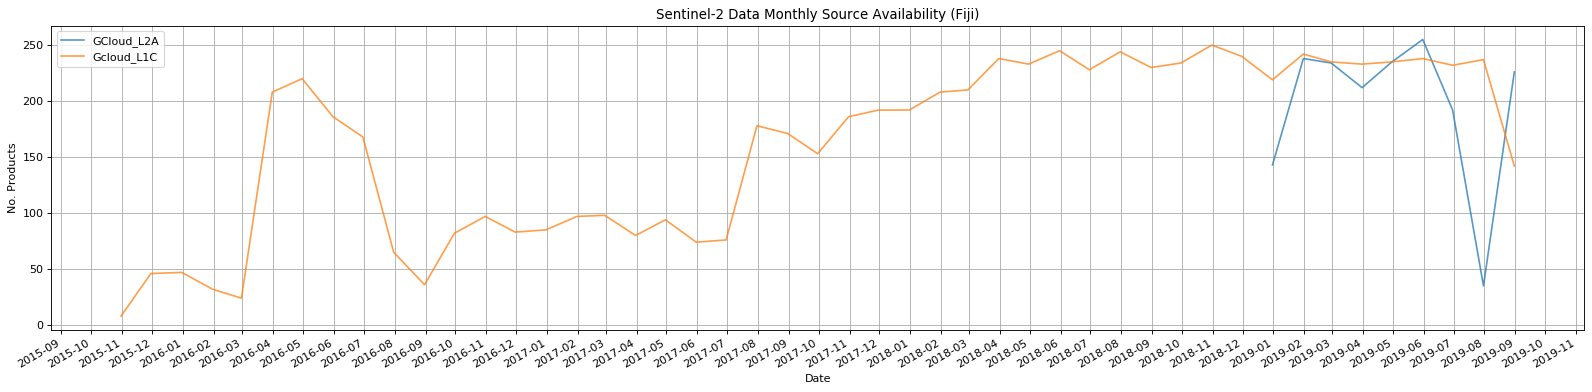

In [23]:
# Create monthly data availability plot from each data source.
fig, ax = plt.subplots(figsize=(20,5),dpi=80)
fig.autofmt_xdate()

# df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_GCL.csv')
df = gc_fj
#print('ASF GRD \n', 'No. Prods: ', len(df), 'Vol Prods (TB): ', df['Size (MB)'].sum()/1000000)
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['SENSING_TIME'], format='%Y-%m-%dT%H:%M:%S', utc=True)
print ('No. GCloud prods before removing products of NaN size', df.shape[0] )
df = df.dropna(subset=['TOTAL_SIZE'])
print ('No. GCloud prods after  removing products of NaN size', df.shape[0] )
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, alpha = 0.75);

# df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_GCL.csv')
df = gc_fj1
#print('ASF GRD \n', 'No. Prods: ', len(df), 'Vol Prods (TB): ', df['Size (MB)'].sum()/1000000)
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['SENSING_TIME'], format='%Y-%m-%dT%H:%M:%S', utc=True)
print ('No. GCloud prods before removing products of NaN size', df.shape[0] )
df = df.dropna(subset=['TOTAL_SIZE'])
print ('No. GCloud prods after  removing products of NaN size', df.shape[0] )
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, alpha = 0.75);


ax.set_ylabel("No. Products");
ax.set_xlabel("Date");
#ax.set_ylim(0,40)
ax.legend(['GCloud_L2A','Gcloud_L1C','GCloud_L1C','ASF_SLC'], loc='upper left');
#ax.legend.loc('upper left')
ax.set_title('Sentinel-2 Data Monthly Source Availability (Fiji)');
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ) 
ax.grid();
fig.tight_layout();

In [38]:
gc_fj.head()

,GRANULE_ID,PRODUCT_ID,DATATAKE_IDENTIFIER,MGRS_TILE,SENSING_TIME,TOTAL_SIZE,CLOUD_COVER,GEOMETRIC_QUALITY_FLAG,GENERATION_TIME,NORTH_LAT,SOUTH_LAT,WEST_LON,EAST_LON,BASE_URL,Acquisition Date
327524,L2A_T60KWD_A009250_20181213T223003,S2B_MSIL2A_20181213T223009_N0211_R072_T60KWD_2...,GS2B_20181213T223009_009250_N02.11,60KWD,2018-12-13T22:31:19.968000Z,1046730460,20.195225,NaN,2018-12-14T00:07:45.000000Z,-18.989494,-19.984716,176.999713,178.046064,gs://gcp-public-data-sentinel-2/L2/tiles/60/K/...,2018-12-13 22:31:19.968000+00:00
327525,L2A_T60KWE_A009250_20181213T223003,S2B_MSIL2A_20181213T223009_N0211_R072_T60KWE_2...,GS2B_20181213T223009_009250_N02.11,60KWE,2018-12-13T22:31:05.669000Z,1047416399,21.196220,NaN,2018-12-14T00:07:45.000000Z,-18.085650,-19.080819,176.999715,178.043387,gs://gcp-public-data-sentinel-2/L2/tiles/60/K/...,2018-12-13 22:31:05.669000+00:00
327526,L2A_T60KWF_A009250_20181213T223003,S2B_MSIL2A_20181213T223009_N0211_R072_T60KWF_2...,GS2B_20181213T223009_009250_N02.11,60KWF,2018-12-13T22:30:51.180000Z,1040098834,20.376468,NaN,2018-12-14T00:07:45.000000Z,-17.181720,-18.176834,176.999716,178.037886,gs://gcp-public-data-sentinel-2/L2/tiles/60/K/...,2018-12-13 22:30:51.180000+00:00
327527,L2A_T60KWG_A009250_20181213T223003,S2B_MSIL2A_20181213T223009_N0211_R072_T60KWG_2...,GS2B_20181213T223009_009250_N02.11,60KWG,2018-12-13T22:30:36.637000Z,1036330371,4.986782,NaN,2018-12-14T00:07:45.000000Z,-16.278250,-17.273306,176.999718,178.032701,gs://gcp-public-data-sentinel-2/L2/tiles/60/K/...,2018-12-13 22:30:36.637000+00:00
327528,L2A_T60KXD_A009250_20181213T223003,S2B_MSIL2A_20181213T223009_N0211_R072_T60KXD_2...,GS2B_20181213T223009_009250_N02.11,60KXD,2018-12-13T22:31:13.996000Z,108185907,24.318269,NaN,2018-12-14T00:07:45.000000Z,-18.988778,-19.891242,177.949934,178.162996,gs://gcp-public-data-sentinel-2/L2/tiles/60/K/...,2018-12-13 22:31:13.996000+00:00


In [40]:
gc_fj1.head()

,GRANULE_ID,PRODUCT_ID,DATATAKE_IDENTIFIER,MGRS_TILE,SENSING_TIME,TOTAL_SIZE,CLOUD_COVER,GEOMETRIC_QUALITY_FLAG,GENERATION_TIME,NORTH_LAT,SOUTH_LAT,WEST_LON,EAST_LON,BASE_URL,Acquisition Date
536,S2A_OPER_MSI_L1C_TL_MPS__20160919T233908_A0065...,S2A_OPER_PRD_MSIL1C_PDMC_20160920T004953_R072_...,GS2A_20160919T223002_006504_N02.04,60LYH,2016-09-19T22:30:04.461000Z,32412483.0,0.4040,PASSED,1970-01-01T00:00:00.000000Z,-15.367489,-15.973943,178.862818,179.004375,gs://gcp-public-data-sentinel-2/tiles/60/L/YH/...,2016-09-19 22:30:04.461000+00:00
66934,L1C_T01KAU_A001456_20151002T222058,S2A_MSIL1C_20151002T222056_N0204_R029_T01KAU_2...,GS2A_20151002T222056_001456_N02.04,01KAU,2015-10-02T22:20:58.000000Z,5402142.0,0.0000,PASSED,2015-10-02T22:20:58.000000Z,-18.969698,-19.005121,-179.901018,-179.756417,gs://gcp-public-data-sentinel-2/tiles/01/K/AU/...,2015-10-02 22:20:58+00:00
66935,L1C_T01KBU_A001456_20151002T222058,S2A_MSIL1C_20151002T222056_N0204_R029_T01KBU_2...,GS2A_20151002T222056_001456_N02.04,01KBU,2015-10-02T22:20:58.000000Z,32715446.0,47.7574,PASSED,2015-10-02T22:20:58.000000Z,-18.970503,-19.111733,-179.849415,-179.304861,gs://gcp-public-data-sentinel-2/tiles/01/K/BU/...,2015-10-02 22:20:58+00:00
80673,L1C_T01KAU_A001742_20151022T222100,S2A_MSIL1C_20151022T222102_N0204_R029_T01KAU_2...,GS2A_20151022T222102_001742_N02.04,01KAU,2015-10-22T22:21:00.000000Z,7480916.0,0.0000,PASSED,2015-10-22T22:21:00.000000Z,-18.968725,-19.019206,-179.962493,-179.756417,gs://gcp-public-data-sentinel-2/tiles/01/K/AU/...,2015-10-22 22:21:00+00:00
80674,L1C_T01KBU_A001742_20151022T222100,S2A_MSIL1C_20151022T222102_N0204_R029_T01KBU_2...,GS2A_20151022T222102_001742_N02.04,01KBU,2015-10-22T22:21:00.000000Z,40044913.0,41.4431,PASSED,2015-10-22T22:21:00.000000Z,-18.970503,-19.120710,-179.849649,-179.320618,gs://gcp-public-data-sentinel-2/tiles/01/K/BU/...,2015-10-22 22:21:00+00:00


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import geopandas as gpd
from shapely.geometry import Polygon
from shapely import wkt
from shapely import wkb

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.patches as mpatches

from sentinelsat import SentinelAPI
import pandas as pd
import datetime

from utils.utils import reproject_wkt_4326_3460

In [30]:
aois_dir = "../CS_AoIs/"

vanuatu_core = gpd.read_file(aois_dir + 'Vanuatu_Core_WorldBorders_wgs84.geojson')
worldborders = gpd.read_file(aois_dir + 'Solomon_Core_WorldBorders_wgs84.geojson')
fiji_core = gpd.read_file(aois_dir + 'Fiji_Core_WorldBorders_wgs84.geojson')

world_granules = gpd.read_file('../Ancillary_Datasets/sentinel2_tiles_world/sentinel2_tiles_world.shp')
world_ls_granules = gpd.read_file('../Ancillary_Datasets/WRS2_descending.shp')

In [37]:
print(worldborders.geometry.values[0])
worldborders.head()

POLYGON ((156.8449710000001 -8.118332000000001, 156.827759 -8.121665999999999, 156.8224790000002 -8.120277, 156.7949830000001 -8.106942999999999, 156.786652 -8.101388999999999, 156.7833250000001 -8.098055, 156.778595 -8.089167, 156.777771 -8.068056, 156.782745 -8.055279000000001, 156.787476 -8.055834000000001, 156.80246 -8.059998999999999, 156.829956 -8.076389000000001, 156.84079 -8.092499, 156.8457950000002 -8.108055, 156.8469240000002 -8.113611000000001, 156.8449710000001 -8.118332000000001))


,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry
0,BP,SB,SLB,90,Solomon Islands,2799,472419,9,54,160.109,-9.611,POLYGON ((156.8449710000001 -8.118332000000001...
1,BP,SB,SLB,90,Solomon Islands,2799,472419,9,54,160.109,-9.611,"POLYGON ((161.387482 -9.468610999999999, 161.3..."
2,BP,SB,SLB,90,Solomon Islands,2799,472419,9,54,160.109,-9.611,"POLYGON ((157.207458 -8.270279, 157.202759 -8...."
3,BP,SB,SLB,90,Solomon Islands,2799,472419,9,54,160.109,-9.611,"POLYGON ((161.97467 -9.853054, 161.969421 -9.8..."
4,BP,SB,SLB,90,Solomon Islands,2799,472419,9,54,160.109,-9.611,"POLYGON ((156.598846 -8.203054, 156.594116 -8...."


In [39]:
print(world_granules.geometry.values[0])
world_granules.head()

POLYGON Z ((180.0000000000001 -73.05973740799993 0, 176.864623786 -72.99147346299998 0, 177.1893403620001 -72.01247788599994 0, 180.0000000000001 -72.07333117899998 0, 180.0000000000001 -73.05973740799993 0))


,Name,geometry
0,01CCV,POLYGON Z ((180.0000000000001 -73.059737407999...
1,01CCV,"POLYGON Z ((-180 -72.07333117899998 0, -179.62..."
2,01CDH,POLYGON Z ((180.0000000000001 -83.808545835999...
3,01CDH,"POLYGON Z ((-180 -82.82590260499995 0, -176.29..."
4,01CDJ,POLYGON Z ((180.0000000000001 -82.913439054999...


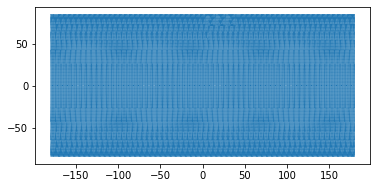

In [26]:
world_s2_granules.plot()

In [31]:
world_granules['inter'] = world_granules.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(worldborders))

ValueError: Wrong number of items passed 33, placement implies 1

In [16]:
print(world_s2_granules.geometry.values[0])

POLYGON Z ((180.0000000000001 -73.05973740799993 0, 176.864623786 -72.99147346299998 0, 177.1893403620001 -72.01247788599994 0, 180.0000000000001 -72.07333117899998 0, 180.0000000000001 -73.05973740799993 0))


In [19]:
world_s2_granules['geometry'] = world_s2_granules.geometry.apply(lambda x: wkb.loads(wkb.dumps(x, output_dimension=2)))

In [22]:
world_s2_granules['inter'] = world_s2_granules.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(solomon_core))

Exception ignored in: <function BaseGeometry.__del__ at 0x7fc42cd23050>
Traceback (most recent call last):
  File "/home/tj/miniconda3/envs/cs/lib/python3.7/site-packages/shapely/geometry/base.py", line 233, in __del__
    def __del__(self):
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
s2_fiji_granules = world_s2_granules[world_s2_granules.Fiji==True]

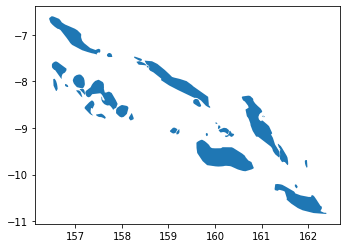

In [12]:
solomon_core.plot()

In [11]:
world_ls_granules['SI'] = world_ls_granules.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(solomon_core))

ValueError: Wrong number of items passed 33, placement implies 1

In [ ]:
ls_fiji_granules = world_ls_granules[world_ls_granules.Fiji==True]

In [7]:
worldborders = gpd.read_file(aois_dir + '/Z_Fiji_WorldBorders_3460.geojson')
overall_aoi = gpd.read_file(aois_dir + '/Fiji_Overall_wgs84.geojson')
overall_aoi_wkt = overall_aoi.geometry.values[0].wkt
overall_aoi_loc = overall_aoi.to_crs({'init': 'epsg:3460'})
core_aoi = gpd.read_file(aois_dir + '/Fiji_VitiLevu_WorldBorders_wgs84.geojson')
core_aoi_loc = core_aoi.to_crs({'init': 'epsg:3460'})
core2_aoi = gpd.read_file(aois_dir + '/Fiji_VitiLevuVanuaLevu_WorldBorders_wgs84.geojson')
lspr = gpd.read_file('../CS_OpenData_AreasOfInterest/Fiji_Landsat_PathRow_fijicrs_new.geojson')

search_outputs_dir = "../CS_OpenData_SearchResults/"

# **Data Estimates Over Fiji**

In [9]:
# Query ESA Open Access Hub
esa_api = SentinelAPI('tmj21','Welcome12!')
base = search_outputs_dir
aoi = 'fiji_overall'

In [204]:
sensor = 's1'
src = 'esa'
res = esa_api.query(overall_aoi_wkt,platformname='Sentinel-1',producttype='SLC',sensoroperationalmode='IW')
esa_api.to_geodataframe(res).to_csv("{}{}_{}_{}_{}.csv".format(base, aoi, sensor, 'slc', src))
res = esa_api.query(overall_aoi_wkt,platformname='Sentinel-1',producttype='GRD',sensoroperationalmode='IW')
esa_api.to_geodataframe(res).to_csv("{}{}_{}_{}_{}.csv".format(base, aoi, sensor, 'grd', src))
sensor = 's2'
res = esa_api.query(overall_aoi_wkt,platformname='Sentinel-2',producttype='S2MSI1C')
esa_api.to_geodataframe(res).to_csv("{}{}_{}_{}_{}.csv".format(base, aoi, sensor, 'l1c', src))
res = esa_api.query(overall_aoi_wkt,platformname='Sentinel-2',producttype='S2MSI2A')
esa_api.to_geodataframe(res).to_csv("{}{}_{}_{}_{}.csv".format(base, aoi, sensor, 'l2a', src))

# Landsat taken from - https://www.usgs.gov/land-resources/nli/landsat/bulk-metadata-service
pr = lspr
sensor = 'ls'
src = 'usgs'
df = pd.read_csv('../Ancillary_Datasets/LANDSAT_8_C1.csv.gz')
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
df.to_csv("{}{}_{}_{}_{}.csv".format(base, aoi, sensor, '8', src))

df = pd.read_csv('../Ancillary_Datasets/LANDSAT_TM_C1.csv.gz')
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
df.to_csv("{}{}_{}_{}_{}.csv".format(base, aoi, sensor, 'TM', src))

df = pd.read_csv('../Ancillary_Datasets/LANDSAT_MSS_C1.csv.gz')
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
df.to_csv("{}{}_{}_{}_{}.csv".format(base, aoi, sensor, 'MSS', src))

df = pd.read_csv('../Ancillary_Datasets/LANDSAT_ETM_C1.csv.gz')
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
df.to_csv("{}{}_{}_{}_{}.csv".format(base, aoi, sensor, 'ETM', src))

Querying products: 100%|██████████| 2553/2553 [01:18<00:00, 28.87 products/s]


### Frames + extents

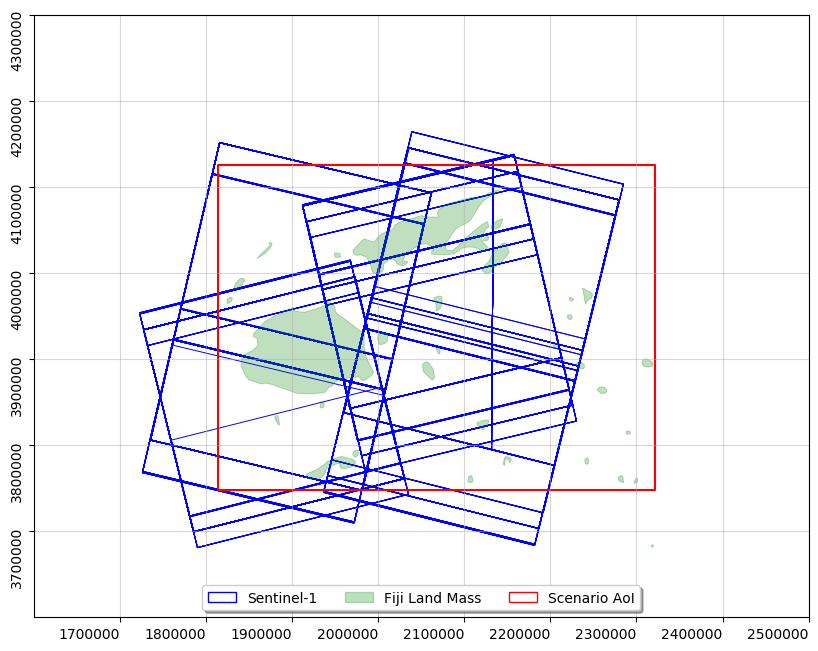

In [218]:
fig, ax = plt.subplots(figsize=(10,10),dpi=100)
fig.autofmt_xdate()
leg_patches=[]

# # S2
# df = pd.read_csv(search_outputs_dir + 'fiji_overall_s2_l1c_esa.csv')
# df['s2platform'] = df['identifier'].str[:3]
# df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
# # df = df[(df['Acquisition Date']>pd.Timestamp("2017-01-01", tz='utc')) & (df['Acquisition Date']<pd.Timestamp("2020-1-1", tz='utc'))]
# df['geometry'] = df['geometry'].apply(wkt.loads)
# df['geometry'] = df['geometry'].apply(lambda x: reproject_wkt_4326_3460(str(x)))
# df['geometry'] = df['geometry'].apply(wkt.loads)
# gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=('epsg:3460'))
# gdf.plot(facecolor="none", edgecolor='g', lw=0.7, ax=ax, alpha=0.5)
# leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='g', label='Sentinel-2', alpha=0.5))

# S1 = SAME IN ANY SCENARIO
df = pd.read_csv(search_outputs_dir + 'fiji_overall_s1_grd_esa.csv')
df['s1platform'] = df['identifier'].str[:3]
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
# df = df[(df['Acquisition Date']>pd.Timestamp("2017-01-01", tz='utc')) & (df['Acquisition Date']<pd.Timestamp("2020-1-1", tz='utc'))]
df['geometry'] = df['geometry'].apply(wkt.loads)
df['geometry'] = df['geometry'].apply(lambda x: reproject_wkt_4326_3460(str(x)))
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=('epsg:3460'))
gdf.plot(facecolor="none", edgecolor='b', lw=0.7, ax=ax)
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='b', label='Sentinel-1'))

# # LS
# lspr.plot(facecolor="none", edgecolor='y', alpha=1, lw=1, ax=ax)
# leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='y', alpha=1, label='Landsat'))

# WORLD BORDERS
worldborders.plot(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, ax=ax)
leg_patches.append(mpatches.Patch(facecolor='g',edgecolor='g', alpha=0.25, label='Fiji Land Mass'))

# SCENARIO AOI
overall_aoi_loc.envelope.plot(facecolor="none", edgecolor='r', lw=1.5, ax=ax)
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='red', label='Scenario AoI'))

#ax.set_title('Fiji Scenario 1: Viti Levu only')
ax.legend(handles=leg_patches, loc='lower center', shadow=True, ncol=5);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);
ax.set_xlim(1600001, 2500000);
ax.set_ylim(3600001, 4300000);

### Temporal Coverage: Monthly Volumes

/home/tj/miniconda3/envs/cs/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/home/tj/miniconda3/envs/cs/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


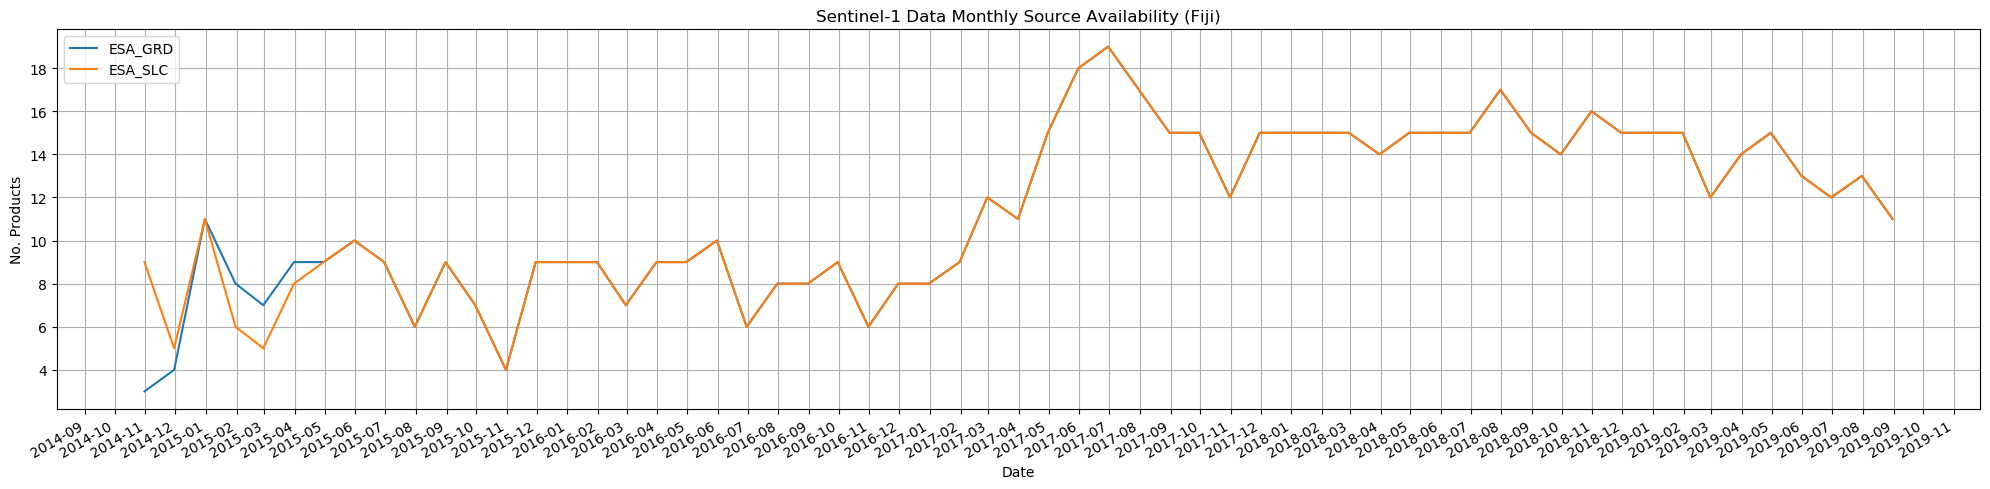

In [18]:
# Create monthly data availability plot from each data source.
fig, ax = plt.subplots(figsize=(20,5),dpi=100)
fig.autofmt_xdate()

df = pd.read_csv(search_outputs_dir + 'fiji_overall_s1_slc_esa.csv')
#print('ESA GRD \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%dT%H:%M:%S', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values);

df = pd.read_csv(search_outputs_dir + 'fiji_overall_s1_grd_esa.csv')
#print('ESA SLC \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%dT%H:%M:%S', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values);

#'bD-.'
ax.set_ylabel("No. Products");
ax.set_xlabel("Date");
#ax.set_ylim(0,40)
ax.legend(['ESA_GRD','ESA_SLC'], loc='upper left');
#ax.legend.loc('upper left')
ax.set_title('Sentinel-1 Data Monthly Source Availability (Fiji)');
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ) 
ax.grid();
fig.tight_layout();
# fig.savefig('../Search_Discovery/Fiji_S1_Monthly_Source_Availability');

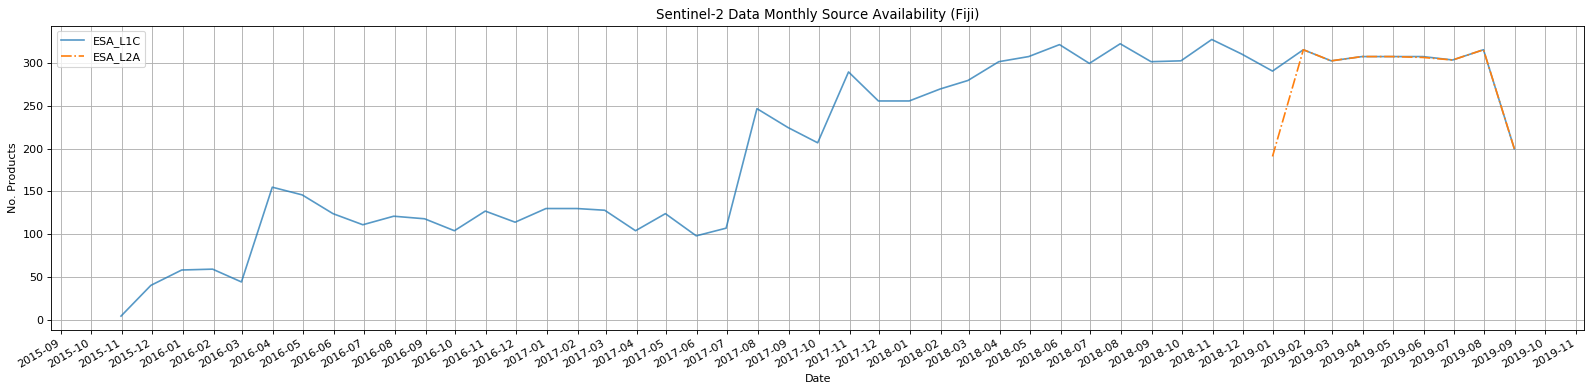

In [26]:
# Create monthly data availability plot from each data source.
fig, ax = plt.subplots(figsize=(20,5),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv(search_outputs_dir + 'fiji_overall_s2_l1c_esa.csv')
#print('ESA GRD \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%dT%H:%M:%S', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, alpha=0.75);

df = pd.read_csv(search_outputs_dir + 'fiji_overall_s2_l2a_esa.csv')
#print('ESA SLC \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%dT%H:%M:%S', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, ls='dashdot');


#'bD-.'
ax.set_ylabel("No. Products");
ax.set_xlabel("Date");
#ax.set_ylim(0,40)
ax.legend(['ESA_L1C','ESA_L2A','GCloud_L1C','ASF_SLC'], loc='upper left');
#ax.legend.loc('upper left')
ax.set_title('Sentinel-2 Data Monthly Source Availability (Fiji)');
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ) 
ax.grid();
fig.tight_layout();
#fig.savefig('../Search_Discovery/Fiji_S1_Monthly_Source_Availability');

Landsat 8 
 No. Prods:  1638
Landsat ETM 
 No. Prods:  1255
Landsat TM 
 No. Prods:  129
Landsat MSS 
 No. Prods:  63


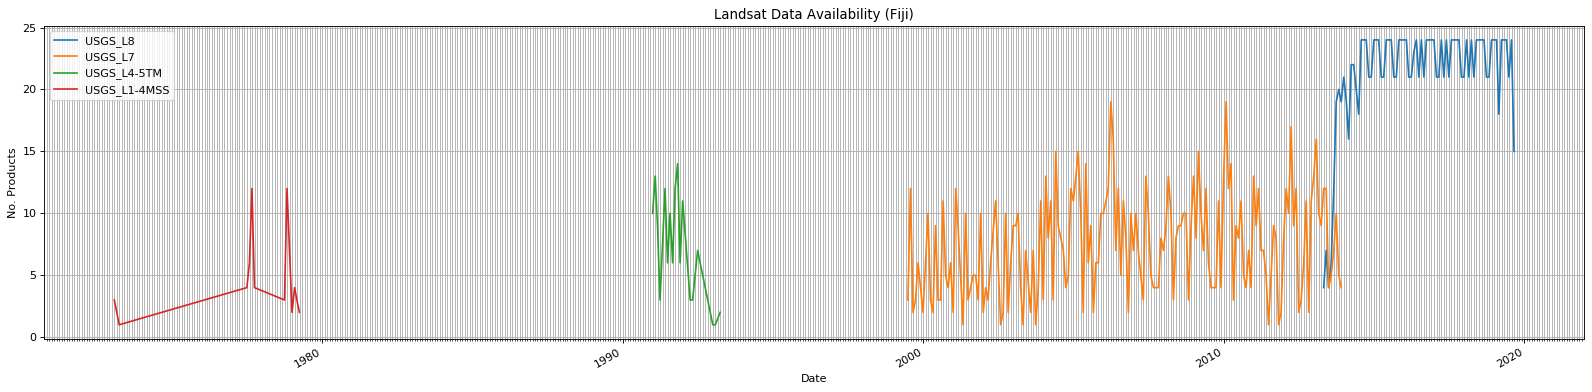

In [25]:
fig, ax = plt.subplots(figsize=(20,5),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv(search_outputs_dir + 'fiji_overall_ls_8_usgs.csv')
#print('Landsat 8 \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values);

df = pd.read_csv(search_outputs_dir + 'fiji_overall_ls_ETM_usgs.csv')
#print('Landsat ETM \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values);

df = pd.read_csv(search_outputs_dir + 'fiji_overall_ls_TM_usgs.csv')
#print('Landsat TM \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values);

df = pd.read_csv(search_outputs_dir + 'fiji_overall_ls_MSS_usgs.csv')
#print('Landsat MSS \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values);

ax.set_ylabel("No. Products");
ax.set_xlabel("Date");
ax.legend(['USGS_L8','USGS_L7','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title('Landsat Data Availability (Fiji)');
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y") ) 
ax.xaxis.set_minor_locator(mdates.MonthLocator())
#ax.xaxis.set_minor_formatter(DateFormatter("%m") ) 
ax.grid(which='both')
fig.tight_layout()
#fig.savefig('../Search_Discovery/LS_Summary_AqNo');

### Data Volumes

In [55]:
ls_tot = 0
df = pd.read_csv(search_outputs_dir + 'fiji_overall_ls_8_usgs.csv')
ls_tot += len(df)
print('Landsat 8 \n', 'No. Prods: ', len(df))
df = pd.read_csv(search_outputs_dir + 'fiji_overall_ls_ETM_usgs.csv')
ls_tot += len(df)
print('Landsat ETM \n', 'No. Prods: ', len(df))
df = pd.read_csv(search_outputs_dir + 'fiji_overall_ls_TM_usgs.csv')
ls_tot += len(df)
print('Landsat TM \n', 'No. Prods: ', len(df))
df = pd.read_csv(search_outputs_dir + 'fiji_overall_ls_MSS_usgs.csv')
ls_tot += len(df)
print('Landsat MSS \n', 'No. Prods: ', len(df))
print('TOTAL LANDSAT \n', 'No. Prods: ', ls_tot)
print(' Rough storage est.: ', (ls_tot * 500)/1000000, 'TB' ) # est avg filesize 500 MB

df = pd.read_csv(search_outputs_dir + 'fiji_overall_s1_grd_esa.csv')
s1_tot = len(df)
print('TOTAL SENTINEL-1 \n', 'No. Prods: ', len(df))
print(' Rough storage est.: ', (s1_tot * 1500)/1000000, 'TB' ) # est avg filesize 1500 MB

df = pd.read_csv(search_outputs_dir + 'fiji_overall_s2_l1c_esa.csv')
s1_tot = len(df)
print('TOTAL SENTINEL-2 \n', 'No. Prods: ', len(df))
print(' Rough storage est.: ', (s1_tot * 750)/1000000, 'TB' ) # est avg filesize 750 MB

Landsat 8 
 No. Prods:  1638
Landsat ETM 
 No. Prods:  1255
Landsat TM 
 No. Prods:  129
Landsat MSS 
 No. Prods:  63
TOTAL LANDSAT 
 No. Prods:  3085
 Rough storage est.:  1.5425 TB
TOTAL SENTINEL-1 
 No. Prods:  672
 Rough storage est.:  1.008 TB
TOTAL SENTINEL-2 
 No. Prods:  9630
 Rough storage est.:  7.2225 TB


In [33]:
df.head(2)
for i in df.columns.values: print(i)

Unnamed: 0
PANCHROMATIC_LINES
NADIR_OFFNADIR
sunAzimuth
REFLECTIVE_SAMPLES
upperLeftCornerLongitude
cloudCover
MAP_PROJECTION_L1
cartURL
sunElevation
path
BPF_NAME_TIRS
THERMAL_LINES
GROUND_CONTROL_POINTS_MODEL
row
imageQuality1
REFLECTIVE_LINES
ELLIPSOID
GEOMETRIC_RMSE_MODEL
browseURL
browseAvailable
dayOrNight
CPF_NAME
DATA_TYPE_L1
THERMAL_SAMPLES
upperRightCornerLatitude
lowerLeftCornerLatitude
sceneStartTime
dateUpdated
sensor
PANCHROMATIC_SAMPLES
GROUND_CONTROL_POINTS_VERSION
LANDSAT_PRODUCT_ID
acquisitionDate
upperRightCornerLongitude
PROCESSING_SOFTWARE_VERSION
GRID_CELL_SIZE_REFLECTIVE
lowerRightCornerLongitude
lowerRightCornerLatitude
sceneCenterLongitude
COLLECTION_CATEGORY
GRID_CELL_SIZE_PANCHROMATIC
BPF_NAME_OLI
sceneCenterLatitude
CLOUD_COVER_LAND
lowerLeftCornerLongitude
GEOMETRIC_RMSE_MODEL_X
GEOMETRIC_RMSE_MODEL_Y
sceneStopTime
upperLeftCornerLatitude
UTM_ZONE
DATE_L1_GENERATED
GRID_CELL_SIZE_THERMAL
DATUM
COLLECTION_NUMBER
sceneID
RLUT_FILE_NAME
TIRS_SSM_MODEL
ROLL_ANG